In [2]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in STOR 120

def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y
    
def r_table(r):
    """
    Generate a table of 1000 data points with a correlation approximately r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

## Linear regression: defining the line

In [4]:
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

In [5]:
def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)

In [6]:
def slope(t, x, y):
    """t is a table; x and y are column labels"""
    r = correlation(t, x, y)
    slope_xy = r * np.std(t.column(y)) / np.std(t.column(x))
    return slope_xy

In [7]:
def intercept(t, x, y):
    """t is a table; x and y are column labels"""
    slope_xy = slope(t, x, y)
    intercept_xy = np.average(t.column(y) - slope_xy * np.average(t.column(x)))
    return intercept_xy

In [8]:
another_example = r_table(-0.7)

ae_slope = slope(another_example, 'x', 'y')
ae_intercept = intercept(another_example, 'x', 'y')

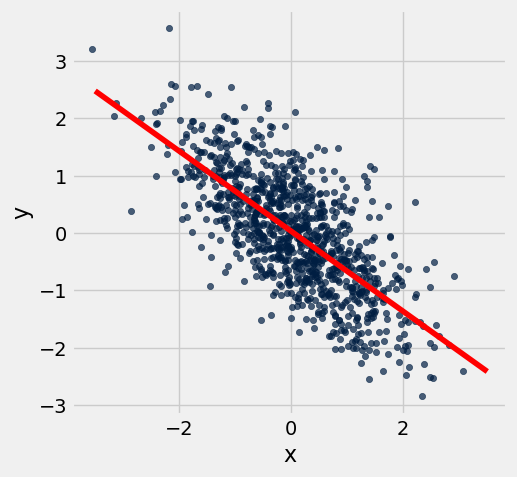

In [9]:
another_example.scatter('x', 'y')
draw_line(
    slope = ae_slope, 
    intercept = ae_intercept, 
    x = make_array(-3.5, 3.5), 
    color='r'
)

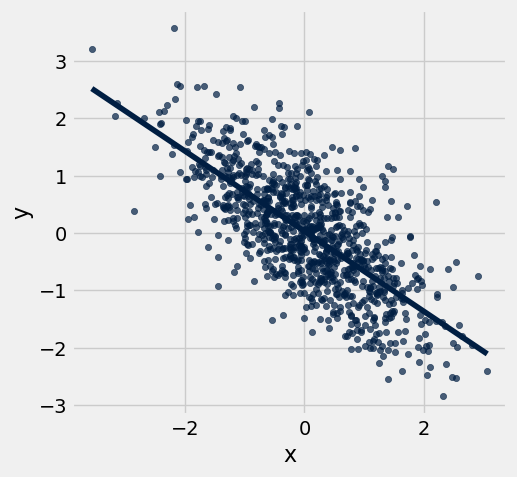

In [10]:
another_example.scatter('x', 'y', fit_line=True)

## Prediction

In [11]:
demographics = Table.read_table('district_demographics2016.csv')
demographics.show(5)

In [12]:
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')
demographics.show(5)

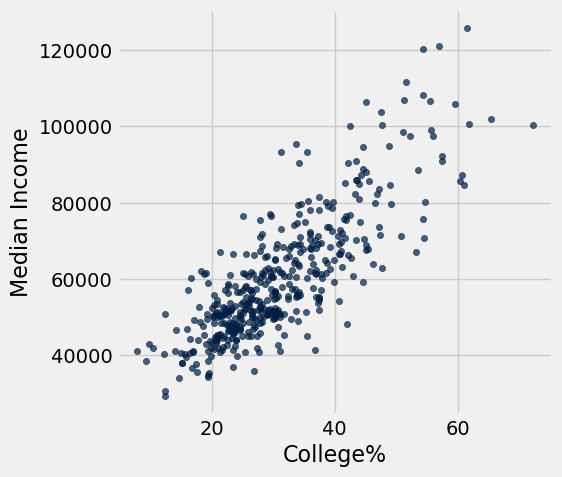

In [13]:
demographics.scatter('College%', 'Median Income')

In [14]:
correlation(demographics, 'College%', 'Median Income')

0.81846485171413352

In [15]:
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

(1270.70168946388, 20802.577766677925)

In [16]:
# For 50% College 

regression_intercept + regression_slope*50

84337.662239871919

In [17]:
def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

In [18]:
predicted = fitted_values(demographics, 'College%', 'Median Income')

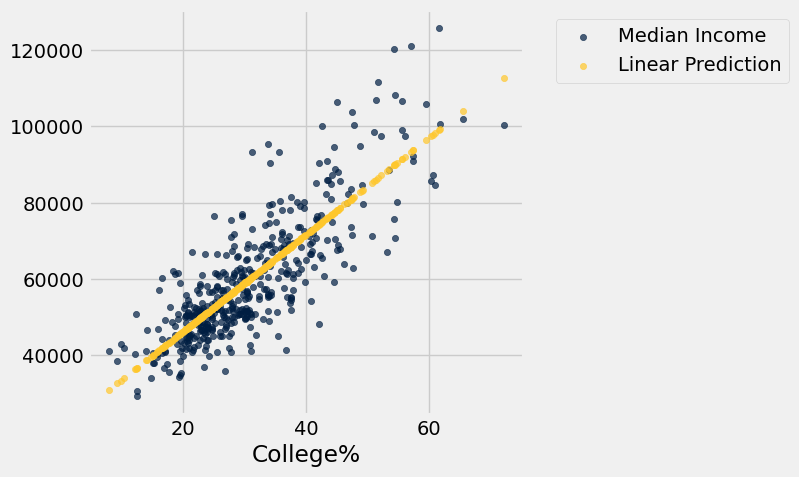

In [19]:
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

## Errors

In [20]:
actual = demographics.column('Median Income')
errors = actual - predicted

In [21]:
demographics.with_column('Error', errors)

Median Income | College% | Linear Prediction | Error
47083         | 24       | 51299.4           | -4216.42
42035         | 21.8     | 48503.9           | -6468.87
46544         | 22.8     | 49774.6           | -3230.58
41110         | 17       | 42404.5           | -1294.51
51690         | 30.3     | 59304.8           | -7614.84
61413         | 36.7     | 67437.3           | -6024.33
34664         | 19.4     | 45454.2           | -10790.2
76440         | 29.6     | 58415.3           | 18024.7
50537         | 24.5     | 51934.8           | -1397.77
49072         | 34       | 64006.4           | -14934.4
... (425 rows omitted)

In [22]:
np.mean(errors)

6.3560089503211536e-13

In [23]:
np.mean(errors ** 2) ** 0.5

9398.5155885712811

In [24]:
def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

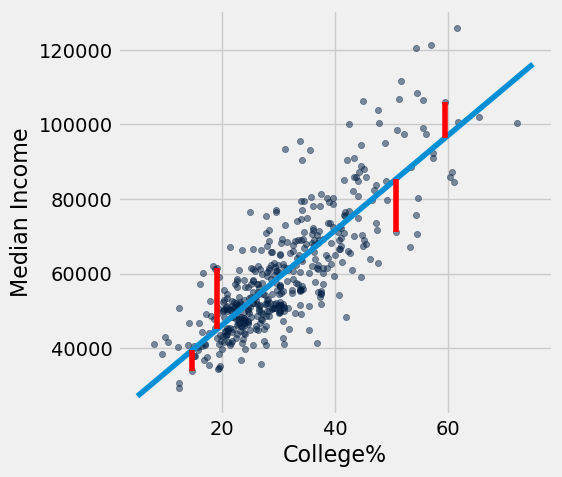

In [25]:
demographics_errors(regression_slope, regression_intercept)

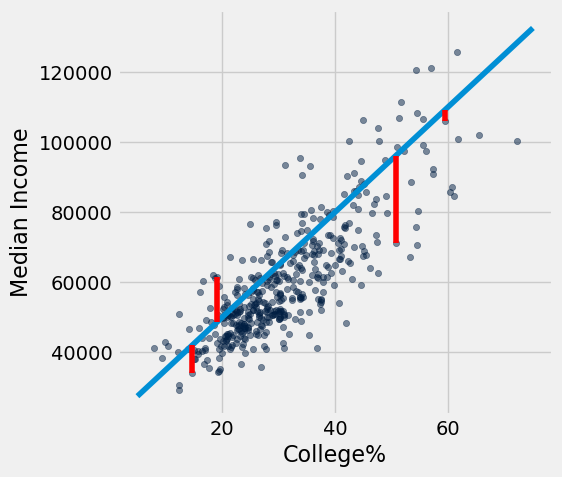

In [26]:
# takes any slope, any intercept

demographics_errors(1500, 20000)

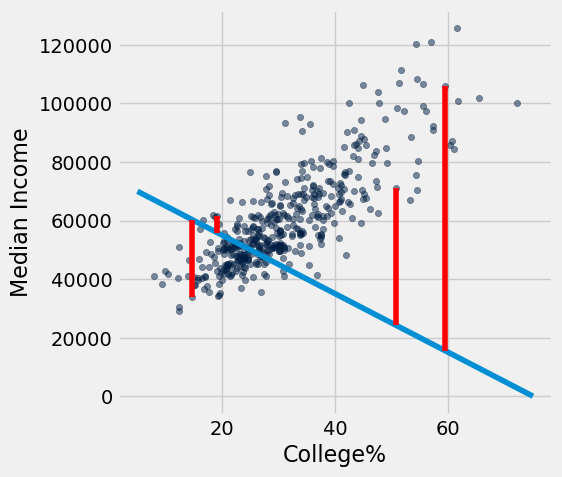

In [27]:
demographics_errors(-1000, 75000)

## Numerical Optimization ###

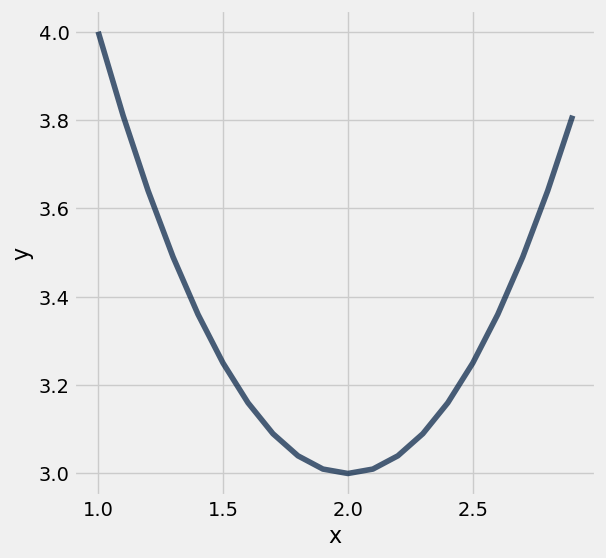

In [28]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [29]:
def f(x):
    return ((x-2)**2) + 3

In [30]:
minimize(f)

1.9999999946252267

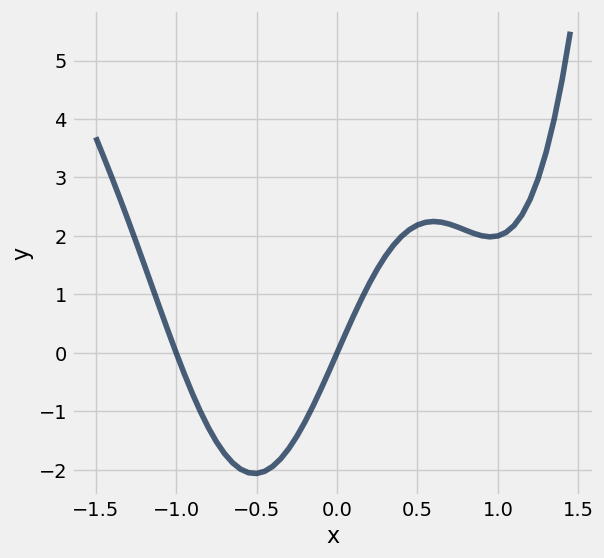

In [31]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 
Table().with_columns('x', x, 'y', y2).plot('x')

In [32]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

In [33]:
minimize(complicated_function)

-0.5126437620940081

### Minimizing RMSE ###

In [34]:
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

11559.086490075999

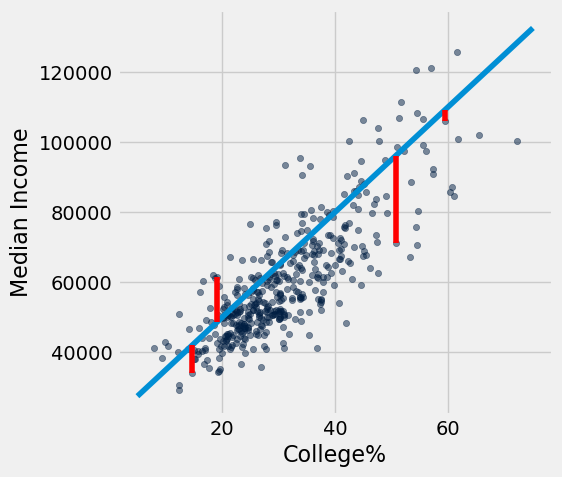

In [35]:
demographics_errors(1500, 20000)
demographics_rmse(1500, 20000)

30247.883767944502

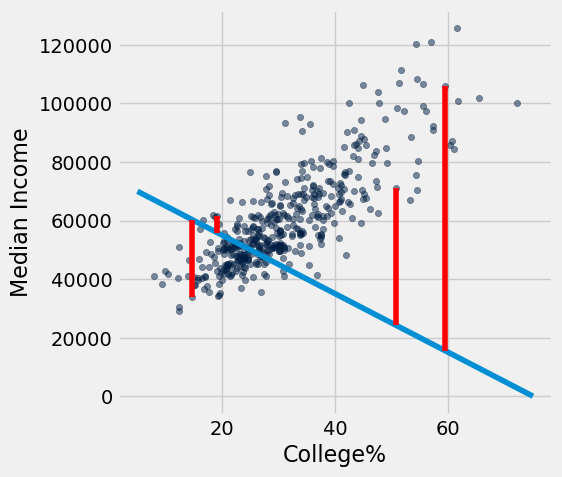

In [36]:
demographics_errors(-1000, 75000)
demographics_rmse(-1000, 75000)

In [37]:
minimize(demographics_rmse)

array([  1270.70168805,  20802.57933807])

In [38]:
make_array(regression_slope, regression_intercept)

array([  1270.70168946,  20802.57776668])